In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import scipy.io
import scipy.interpolate
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import matplotlib.colors as colors
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [ ]:
# Load files feaSubEImg_1.csv, feaSubEImg_2.csv, feaSubEOvert_1.csv, feaSubEOvert_2.csv, sensors102.mat
uploads = files.upload()

img1 = pd.read_csv("feaSubEImg_1.csv", header = None).T
img2 = pd.read_csv("feaSubEImg_2.csv", header = None).T
ov1 = pd.read_csv("feaSubEOvert_1.csv", header = None).T
ov2 = pd.read_csv("feaSubEOvert_2.csv", header = None).T

img_features = img1
img_features = img_features.append(img2)
ov_features = ov1
ov_features = ov_features.append(ov2)

img1_truth = np.ones(img1.shape[0])
img2_truth = np.ones(img2.shape[0])*2
ov1_truth =np.ones(ov1.shape[0])
ov2_truth = np.ones(ov2.shape[0])*2

img_truth = img1_truth
img_truth = np.append(img_truth, img2_truth)
ov_truth = ov1_truth
ov_truth = np.append(ov_truth, ov2_truth)

Saving feaSubEImg_1.csv to feaSubEImg_1 (1).csv
Saving feaSubEImg_2.csv to feaSubEImg_2 (1).csv
Saving feaSubEOvert_1.csv to feaSubEOvert_1 (1).csv
Saving feaSubEOvert_2.csv to feaSubEOvert_2 (1).csv
Saving sensors102.mat to sensors102 (1).mat


(120, 204)


Text(0.5, 1.0, 'Linear Separation of Left and Right EEG Partial Signals')

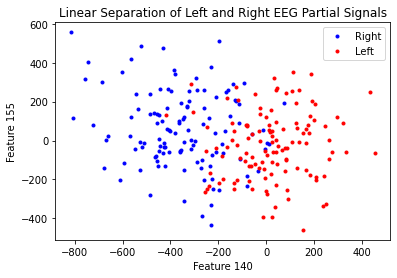

In [ ]:
print(img1.shape)
plt.plot(ov1.iloc[:, 140], ov1.iloc[:, 155], 'b.', label='Right')
plt.plot(ov2.iloc[:, 140], ov2.iloc[:, 155], 'r.', label='Left')
plt.legend()
plt.xlabel("Feature 140")
plt.ylabel("Feature 155")
plt.title('Linear Separation of Left and Right EEG Partial Signals')

In [ ]:
# Plot channel weights on the brain surface
def show_chanWeights(chanVal, data_title, regularization_title):
	matlab_offset = 1

	selNum = np.asarray(range(1,306))
	cortIX = np.where(np.mod(selNum, 3)!=0)
	selNum = selNum[cortIX]

	resolution = 200

	# Load sensor location
	#load sensors102.mat
	mat = scipy.io.loadmat('sensors102.mat')
	c102 = mat['c102']
	x = c102[:, 2 - matlab_offset]
	y = c102[:, 3 - matlab_offset]
	xlin = np.linspace(min(x), max(x) + 35, resolution)
	ylin = np.linspace(min(y), max(y), resolution)
	r = 5

	MinChanVal = min(chanVal)
	z = np.ones(len(x)) * MinChanVal

	selSen = np.ceil(selNum / 3)

	maxSen = int(max(selSen))
	for senIX in range(1, maxSen):
		currVal = np.zeros(2)
		for chanIX in range(1, 2):
			chanInd = (senIX - 1) * 3 + chanIX
			tmp = np.where(selNum == chanInd)
			if len(tmp) != 0:
				currVal[chanIX - matlab_offset] = chanVal[tmp]
		z[senIX] = max(currVal)

	X, Y = np.meshgrid(xlin, ylin)
	Z = scipy.interpolate.griddata((x, y), z, (X, Y), method='cubic')
	plt.title("Channel Weights on Brain Surface for Fold #1: " + data_title + " Data w/ " + regularization_title + " Regularization")
	plt.pcolor(Z, cmap="plasma")
	plt.axis('equal')  # ax.axis('equal')
	plt.axis('off')
	plt.colorbar()
	plt.show()

In [ ]:
# Two class linear svm classifer
import heapq

def svm_classifier(features, truth, penalty, data_title, regularization_title):
  clf = make_pipeline(StandardScaler(), LinearSVC(penalty=penalty, random_state=1, tol=1e-5, max_iter=10000, dual=False))
  dec_stats = np.empty((0,3), float)
  predictions = np.empty((0,3), int)
  predictions_fold = []
  truth_out = np.empty((0,3), int)
  show_plots = True
  truth_fold = []
  prob_fold = []
  cv_1 = KFold(n_splits=6, shuffle=True)
  for train_index_1, test_index_1 in cv_1.split(features):
    train_features_1 = features.iloc[train_index_1, :]
    train_truth_1 = truth[train_index_1]
    test_features_1 = features.iloc[test_index_1, :]
    test_truth_1 = truth[test_index_1]
    cv_2 = KFold(n_splits=5, shuffle=True, random_state=1)
    alpha_candidates = [0.01, 1, 100, 10000, 100000, 10000000]
    c_candidates = []
    for a in alpha_candidates:
      c_candidates.append(1/a)
    clf = GridSearchCV(estimator= LinearSVC(penalty=penalty, random_state=1, max_iter=10000, dual=False), param_grid={"C":c_candidates}, n_jobs=-1, cv=cv_2, refit=False)
    clf.fit(train_features_1, train_truth_1)
    print("Reg param: " + str(1/clf.best_params_['C']))
    svm = LinearSVC(penalty=penalty, random_state=1, max_iter=50000, C=clf.best_params_['C'], dual=False)
    svm.fit(train_features_1, train_truth_1)
    decision_function = svm.decision_function(train_features_1)
    support_vector_indices = np.where(
        np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = train_features_1[support_vector_indices]
    print(support_vectors.shape)
    if show_plots:
      plt.plot(svm.coef_.T)
      plt.title("Channel Weights for Fold #1: " + data_title + " Data w/ " + regularization_title + " Regularization")
      plt.xlabel("Channel Number")
      plt.ylabel("Channel Weight")
      plt.figure()
      show_chanWeights(svm.coef_.T, data_title, regularization_title)
      plt.figure()
      show_plots = False
      absValues = abs(svm.coef_.T)
      absValues = absValues.flatten()
      largest_integers = heapq.nlargest(5, absValues)
      print(largest_integers)
      largest_integer_indices = np.in1d(absValues, largest_integers).nonzero()[0]


    predictions = np.append(predictions, svm.predict(test_features_1))
    dec_stats = np.append(dec_stats, svm.decision_function(test_features_1))
    truth_out = np.append(truth_out, test_truth_1)
    prob_fold.append(svm.decision_function(test_features_1))
    predictions_fold.append(svm.predict(test_features_1))
    truth_fold.append(test_truth_1)

  for a in range(6):
    getAccuracy(predictions_fold[a], truth_fold[a], a)
    fpr, tpr, threshold = metrics.roc_curve(truth_fold[a], prob_fold[a], pos_label=2)
    roc_auc = metrics.auc(fpr, tpr)
    print(fpr.shape)
    plt.plot(fpr, tpr, label = 'Fold' + str(a))
  fpr, tpr, threshold = metrics.roc_curve(truth_out, dec_stats, pos_label=2)
  roc_auc = metrics.auc(fpr, tpr)
  print(fpr.shape)
  plt.plot(fpr, tpr, label = 'Overall Data')
  plt.legend(loc = 'lower right')
  plt.title("ROC of SVM Classifier for " + data_title + " Data w/ " + regularization_title + " Regularization")
  count = 0
  print(predictions.shape)
  for x in range(predictions.shape[0]):
    if predictions[x] == truth_out[x]:
      count+=1
  print("Accuracy: " + str(count/predictions.shape[0]))

  return dec_stats, predictions, truth_out

def getAccuracy(predictions, truth_out, a):
  count = 0
  for x in range(predictions.shape[0]):
    if predictions[x] == truth_out[x]:
      count+=1
  print("Accuracy for fold " + str(a) + ": " + str(count/predictions.shape[0]))



Reg param: 10000000.0
(200, 137)


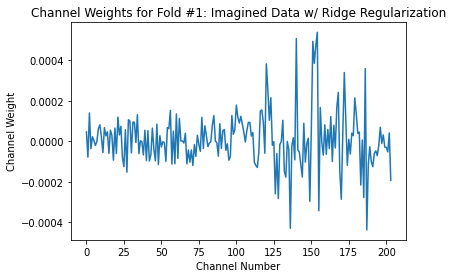

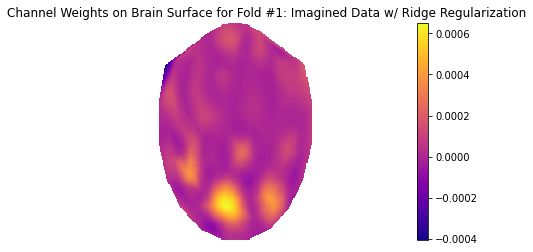

[0.0005386418572832891, 0.000507535555334054, 0.0004936373529758119, 0.00047384535609925466, 0.0004381584303799667]
Reg param: 10000000.0
(200, 130)
Reg param: 10000000.0
(200, 141)
Reg param: 10000000.0
(200, 130)
Reg param: 10000000.0
(200, 133)
Reg param: 10000000.0
(200, 141)
Accuracy for fold 0: 0.95
(6,)
Accuracy for fold 1: 0.8
(18,)
Accuracy for fold 2: 0.975
(6,)
Accuracy for fold 3: 0.725
(6,)
Accuracy for fold 4: 0.875
(10,)
Accuracy for fold 5: 0.875
(10,)
(46,)
(240,)
Accuracy: 0.8666666666666667


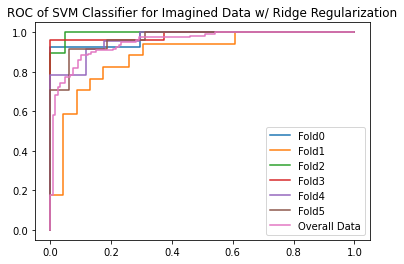

In [ ]:
ridge = 'l2'
lasso = 'l1'
# dec_stats, predictions, truth = svm_classifier(ov_features, ov_truth, lasso, "Overt", "Lasso")
# dec_stats, predictions, truth = svm_classifier(ov_features, ov_truth, ridge, "Overt", "Ridge")
dec_stats, predictions, truth = svm_classifier(img_features, img_truth, ridge, "Imagined", "Ridge")
# dec_stats, predictions, truth = svm_classifier(img_features, img_truth, lasso, "Imagined", "Lasso")